In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA

import itertools
import random

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10) - <b> define shared list of combinations </b>
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [2]:
# ranking is based on distance similarity
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    #output['link'] = output.apply(lambda x: 'www.twitter.com/'+x['username']+'/', axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    # reset_index -> index+1 becomes the ranking
    output.reset_index(inplace=True)
    
    return output

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [4]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [72]:
def plotData(seeds, candidates, components, centroids = None):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')
    
    if centroids is not None:
        for c in centroids:
            plt.scatter(c[0], c[1], marker='o', color='black')

In [6]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [7]:
header = ['{}'.format(i) for i in range(1,9)]

## List of members/candidates combinations

Generate the combinations of ids to be used as actual members (the others are the good candidates by set difference)

In [ ]:
allseeds = map(str, list(pd.read_csv(datapath+'/user.csv', sep='\t')['id_user']))
len(allseeds)

In [ ]:
N = 10
all_combinations = list(itertools.combinations(allseeds, N))
print len(all_combinations)

In [ ]:
shared_combinations = random.sample(all_combinations, 100)

In [ ]:
with open('../all_members_list.pkl', 'w') as alldata:
    pickle.dump(allseeds, alldata)
with open('../combinations.pkl', 'w') as currdata:
    pickle.dump(shared_combinations, currdata)

# Run tests with fixed combinations

In [12]:
allseeds = pickle.load(open('../all_members_list.pkl', 'rb'))
combinations = pickle.load(open('../combinations.pkl', 'rb'))

In [13]:
allseeds

['36361027',
 '104952689',
 '35810531',
 '6361512',
 '31137628',
 '18622869',
 '241709263',
 '397489668',
 '18378349',
 '327577091',
 '7517052',
 '1305698738',
 '22522178',
 '372460791',
 '300868924',
 '211106542',
 '575160556',
 '407347022',
 '36499730',
 '57268394']

In [14]:
len(combinations)

100

In [15]:
domain = 'finance_20'
datapath = 'data-seed/{}/'.format(domain)
seed_data = pd.read_csv(datapath+'/user.csv', sep='\t')

## Nouns Network Test - 1

Average P@20: 6.77


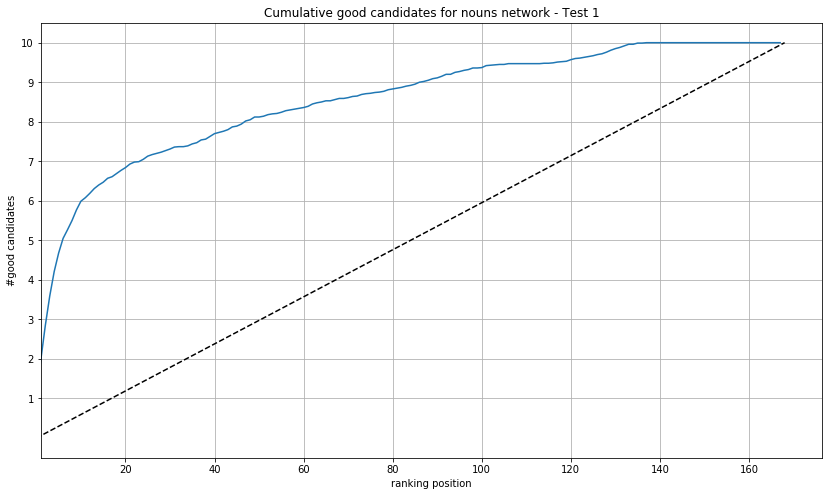

In [17]:
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
        
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'noun_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'user_features_w_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','id_user','username','usertype']+header

    data = data[data['usertype'].isin(['seed','user'])]
    data.reset_index(inplace=True)
    
    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['id_user']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)
    #alldistr = pd.DataFrame(columns=['sim','freq'])
    prec_20 = []
    
    for seeds in combinations:
        effective_seeds = list(seeds)
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)
        
        for index, candidate in r.iterrows():
            id_user = candidate['id_user']
            all_ranking[id_user].append(index+1)
        
        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        #sim_distr = computeSimDistribution(r, 3)
        #alldistr = pd.concat([alldistr, sim_distr])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for nouns network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print 'Average P@20: {:.2f}'.format(np.mean(prec_20))

In [14]:
result = []
for id_user in sorted(candidates_ranking, key=candidates_ranking.get):
    result.append(tuple(
        (seed_data[seed_data['id_user'] == int(id_user)]['screen_name'].values[0], np.mean(candidates_ranking[id_user]))
    ))

In [15]:
pd.DataFrame(result, columns=['screen_name', 'ranking']).sort_values(by='ranking')

,screen_name,ranking
0,economistmeg,1.083333
1,reformedbroker,1.666667
3,katie_martin_fx,1.934783
2,justinwolfers,2.629032
4,laurenlacapra,2.698113
6,queen_europe,4.659574
9,firoozye,5.882353
7,ezraklein,6.065217
5,bill_easterly,7.073171
8,kathylienfx,7.485714


In [16]:
for id_user in candidates_ranking:
    print id_user, candidates_ranking[id_user]

300868924 [63, 42, 72, 50, 50, 50, 25, 88, 50, 92, 60, 57, 41, 86, 93, 48, 53, 64, 17, 50, 32, 48, 38, 50, 63, 38, 62, 57, 65, 74, 47, 82, 26, 20, 61, 47, 47, 27, 65, 36, 54, 77, 45, 69, 93, 49, 73, 52]
6361512 [22, 7, 26, 14, 3, 3, 15, 30, 25, 26, 42, 29, 23, 18, 14, 2, 21, 12, 13, 12, 15, 19, 24, 6, 10, 5, 26, 7, 31, 22, 11, 9, 15, 14, 19, 7, 5, 19, 6, 4, 16, 8, 17, 5, 40, 10, 19, 10, 2, 11, 4, 9, 30, 21, 30, 32, 9]
36361027 [3, 2, 2, 1, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, 4, 3, 3, 2, 3, 1, 3, 2, 1, 2, 3, 5, 3, 4, 3, 2, 2, 2, 1, 4, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 2, 3, 4, 2, 3, 4, 1, 4, 2]
211106542 [17, 48, 8, 5, 12, 13, 10, 13, 17, 8, 4, 6, 19, 11, 13, 20, 12, 15, 37, 44, 9, 5, 5, 23, 7, 18, 7, 13, 15, 22, 8, 11, 22, 6, 11, 37, 27, 8, 31, 6, 7, 20, 4, 11, 6, 5, 25, 29, 22, 16, 7, 7, 21, 14, 7, 22, 15, 10, 10]
7517052 [25, 27, 4, 6, 8, 6, 26, 18, 13, 3, 16, 28, 6, 17, 5, 4, 11, 4, 10, 15, 4, 14, 5, 32, 4, 10, 28, 10, 14, 17, 39, 6, 9, 10, 13, 5, 15, 7, 7, 15, 5, 10, 7, 8, 5, 5, 8, 4, 20, 6,

In [23]:
allresult = []
for id_user in all_ranking:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_ranking[id_user]))
    ))

In [25]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if x['id_user'] in allseeds else 'random', axis=1)

In [28]:
df_all[:20]

,id_user,screen_name,ranking,member
91,241709263,economistmeg,1.083333,seed
62,22522178,reformedbroker,1.666667,seed
32,57268394,katie_martin_fx,1.934783,seed
134,327577091,justinwolfers,2.629032,seed
101,36361027,laurenlacapra,2.698113,seed
139,407347022,queen_europe,4.659574,seed
31,31137628,firoozye,5.882353,seed
60,6936172,mweigel,6.000000,random
52,18622869,ezraklein,6.065217,seed
18,35810531,bill_easterly,7.073171,seed


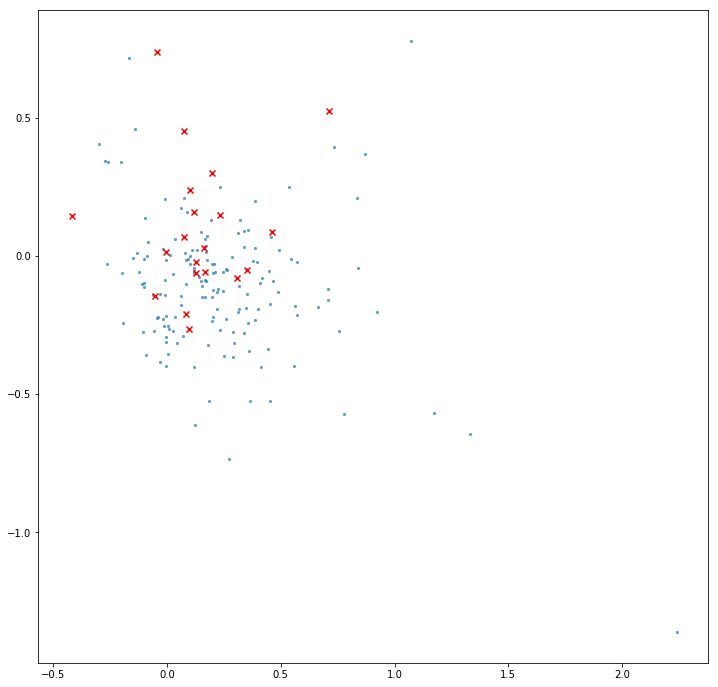

In [18]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Nouns Network Test - All Random

In [23]:
domain = 'finance_20'
path = '{}/random-test/'.format(domain)
randompath = 'data-random/'

In [24]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'noun_network_nodes.csv', sep='\t') # match graph id and user instance
data = pd.read_csv(path+'user_features_noun.emb', sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','id_user','username','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)
data.head()

,index,id_graph,id_user,username,usertype,1,2,3,4,5,6,7,8
0,0,0,36361027,laurenlacapra,seed,-2.89856,1.93564,-3.68447,-2.42179,4.44126,5.23677,2.61690,-1.71369
1,845,845,104952689,lamonicabuzz,seed,-3.02294,1.99816,-3.87449,-2.44990,4.62214,5.29700,2.73009,-1.80683
2,1410,1410,35810531,bill_easterly,seed,-2.89909,1.87014,-3.63816,-2.38163,4.32495,5.06926,2.52970,-1.67351
3,1798,1798,6361512,fgoria,seed,-3.02518,1.89178,-3.69543,-2.28578,4.52761,5.10321,2.59032,-1.76764
4,2199,2199,300868924,eu_eurostat,seed,-3.21636,1.95015,-4.01752,-2.50268,4.85479,5.49657,2.79836,-1.89539


Average P@20: 4.41


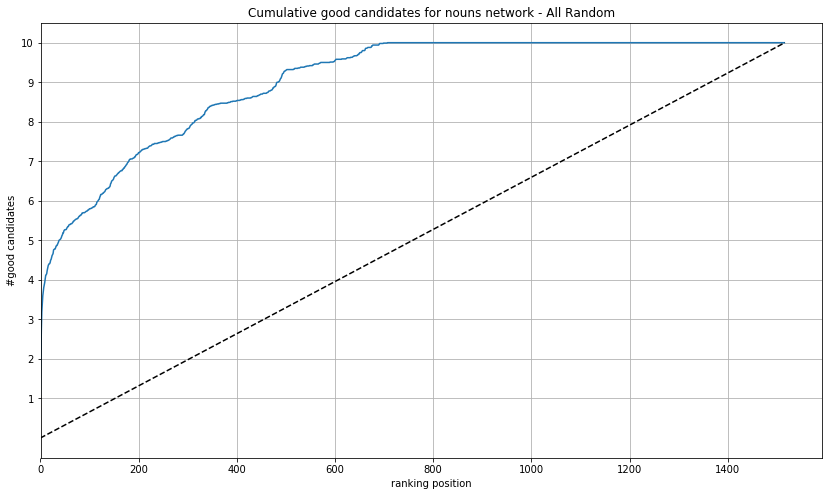

In [25]:
# store the retrieval position of each seed
candidates_ranking = {}
for u in allseeds:
    candidates_ranking[u] = []
    
ysum = np.zeros(data.shape[0] - 10)
#alldistr = pd.DataFrame(columns=['sim','freq'])
prec_20 = []

for seeds in combinations:
    effective_seeds = list(seeds)
    good_candidates = list(set(allseeds)-(set(effective_seeds)))

    seedsVectors = data[data['id_user'].isin(effective_seeds)]
    centroid = computeCentroid(seedsVectors, header)
    candidates = data[~data['id_user'].isin(effective_seeds)]

    r = candidatesRanking(candidates, centroid, header)
    r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
    y = cumulativeGoodCandidates(r)
    ysum = ysum + y

    for index, candidate in r[r['good'] == True].iterrows():
        id_user = candidate['id_user']
        candidates_ranking[id_user].append(index+1)

    #sim_distr = computeSimDistribution(r, 3)
    #alldistr = pd.concat([alldistr, sim_distr])
    prec_20.append(cumulativeGoodCandidates(r[:20])[19])
    
y_avg = ysum.astype(float)/len(combinations)

plt.figure(figsize=(14,8))
plt.title('Cumulative good candidates for nouns network - All Random')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.plot(y_avg)
plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
plt.xlim(xmin=1)

plt.yticks(range(1,11))
plt.grid(True)

print 'Average P@20: {:.2f}'.format(np.mean(prec_20))

In [26]:
result = [] # seed_data[seed_data['id_user'] == int(id_user)]['screen_name'].values[0]
for id_user in sorted(candidates_ranking, key=candidates_ranking.get):
    result.append(tuple(
        (id_user, np.mean(candidates_ranking[id_user]))
    ))

In [27]:
pd.DataFrame(result, columns=['screen_name', 'ranking']).sort_values(by='ranking')

,screen_name,ranking
1,36499730,1.857143
0,36361027,2.320755
7,6361512,2.929825
2,22522178,3.703704
3,575160556,3.731707
5,31137628,7.588235
4,35810531,14.439024
6,18378349,47.360656
11,18622869,57.347826
10,241709263,67.562500


In [28]:
for id_user in candidates_ranking:
    print id_user, candidates_ranking[id_user]

300868924 [556, 462, 539, 311, 470, 432, 530, 483, 368, 433, 402, 568, 531, 489, 355, 382, 493, 556, 393, 430, 229, 591, 447, 302, 308, 466, 559, 558, 261, 446, 603, 410, 519, 455, 434, 292, 294, 384, 541, 549, 227, 517, 490, 346, 422, 388, 329, 496]
6361512 [7, 1, 3, 2, 2, 2, 3, 3, 1, 4, 6, 2, 2, 5, 3, 2, 3, 1, 10, 3, 3, 5, 3, 2, 3, 1, 4, 3, 3, 1, 3, 4, 8, 2, 3, 2, 4, 3, 1, 3, 3, 2, 2, 2, 3, 1, 1, 4, 1, 3, 2, 1, 2, 3, 4, 3, 4]
36361027 [1, 1, 2, 2, 1, 1, 1, 4, 2, 4, 3, 1, 3, 1, 2, 1, 3, 1, 1, 1, 2, 3, 1, 3, 1, 2, 2, 1, 2, 2, 1, 3, 12, 4, 2, 2, 5, 2, 2, 4, 2, 1, 2, 1, 4, 3, 2, 4, 2, 2, 4, 2, 2]
211106542 [264, 450, 298, 263, 417, 345, 245, 181, 343, 400, 321, 178, 248, 233, 207, 408, 315, 182, 365, 449, 474, 240, 265, 336, 42, 519, 266, 70, 478, 214, 204, 389, 295, 443, 277, 454, 304, 144, 272, 526, 217, 86, 297, 113, 295, 204, 146, 38, 86, 85, 197, 318, 443, 333, 233, 477, 342, 83, 338]
7517052 [139, 47, 82, 176, 119, 137, 32, 147, 182, 130, 39, 112, 19, 11, 150, 100, 120, 193, 3, 222

## Hashtags Network Test - 1

Average P@20: 1.69


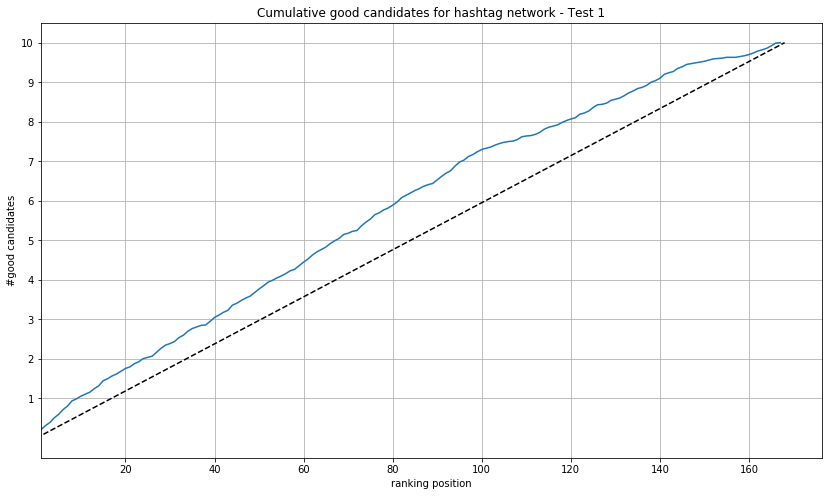

In [15]:
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
        
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'h_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'h_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','username','id_user','usertype']+header

    data = data[data['usertype'].isin(['seed','user'])]
    data.reset_index(inplace=True)
    
    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['id_user']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)
    #alldistr = pd.DataFrame(columns=['sim','freq'])
    prec_20 = []
    
    for seeds in combinations:
        effective_seeds = list(seeds)
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)
        
        for index, candidate in r.iterrows():
            id_user = candidate['id_user']
            all_ranking[id_user].append(index+1)
        
        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        #sim_distr = computeSimDistribution(r, 3)
        #alldistr = pd.concat([alldistr, sim_distr])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for hashtag network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print 'Average P@20: {:.2f}'.format(np.mean(prec_20))

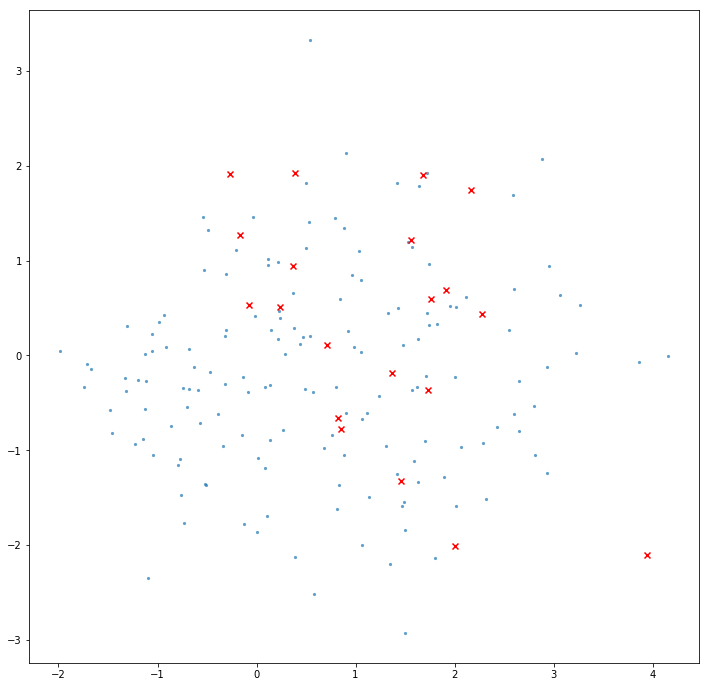

In [16]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Mention Network Test - 1

In [85]:
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
    
    # test ids needed to filter the mentioned users (they are not included in the ranking)
    testusers = pd.read_csv('data-random/user.csv', sep='\t')
    test_ids = map(str, testusers[testusers['n_test'] == test]['id_user'].unique())
    allseeds = list(map(str, allseeds))
    
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'m_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'m_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','username','id_user','usertype']+header
    
    # keeps only seeds and test users for the evaluation
    data = data[(data['usertype'] == 'seed') | (data['id_user'].isin(test_ids))]
    data.reset_index(inplace=True)
    
    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['id_user']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)
    #alldistr = pd.DataFrame(columns=['sim','freq'])
    prec_20 = []
    
    for seeds in combinations:
        effective_seeds = list(seeds)
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)
        
        for index, candidate in r.iterrows():
            id_user = candidate['id_user']
            all_ranking[id_user].append(index+1)
        
        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        #sim_distr = computeSimDistribution(r, 3)
        #alldistr = pd.concat([alldistr, sim_distr])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for mention network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))

KeyError: '1305698738'

In [78]:
result = []
for id_user in sorted(candidates_ranking, key=candidates_ranking.get):
    result.append(tuple(
        (seed_data[seed_data['id_user'] == int(id_user)]['screen_name'].values[0], np.mean(candidates_ranking[id_user]))
    ))

/home/brambilla/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brambilla/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [79]:
pd.DataFrame(result, columns=['screen_name', 'ranking']).sort_values(by='ranking')

,screen_name,ranking
0,laurenlacapra,NaN
1,lamonicabuzz,NaN
2,bill_easterly,NaN
3,fgoria,NaN
4,firoozye,NaN
5,ezraklein,NaN
6,economistmeg,NaN
7,rencapman,NaN
8,keithmccullough,NaN
9,justinwolfers,NaN


In [80]:
for id_user in candidates_ranking:
    print (id_user, candidates_ranking[id_user])

36361027 []
104952689 []
35810531 []
6361512 []
31137628 []
18622869 []
241709263 []
397489668 []
18378349 []
327577091 []
7517052 []
1305698738 []
22522178 []
372460791 []
300868924 []
211106542 []
575160556 []
407347022 []
36499730 []
57268394 []


In [81]:
allresult = []
for id_user in all_ranking:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_ranking[id_user]))
    ))

In [82]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if x['id_user'] in allseeds else 'random', axis=1)

In [83]:
df_all[:20]

,id_user,screen_name,ranking,member
19,57268394,katie_martin_fx,1.347826,random
9,327577091,justinwolfers,2.048387,random
11,1305698738,economisthulk,2.326923,random
15,211106542,dsquareddigest,2.644068,random
12,22522178,reformedbroker,3.481481,random
4,31137628,firoozye,4.235294,random
6,241709263,economistmeg,5.687500,random
10,7517052,howardlindzon,8.588235,random
0,36361027,laurenlacapra,9.660377,random
68,42047590,elliexxsmile,11.170000,random


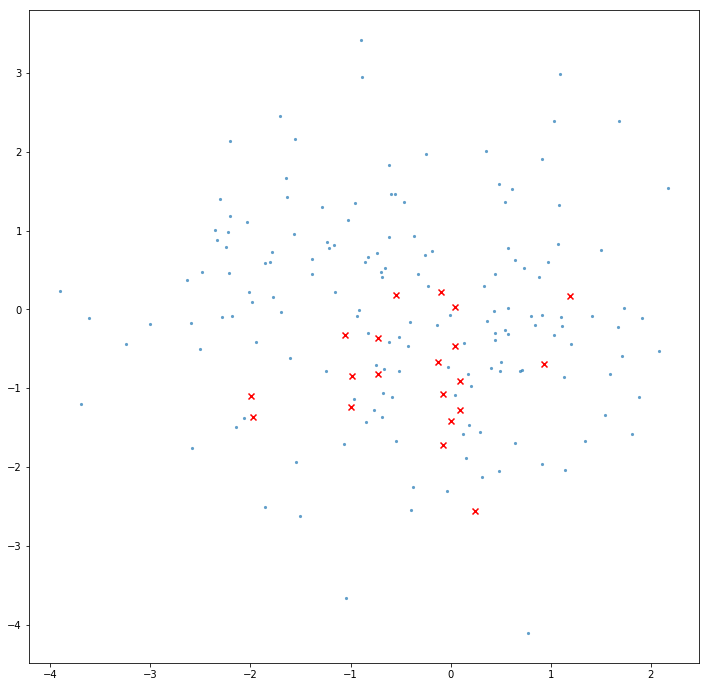

In [84]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Following Network Test - 1

Average P@20: 2.92


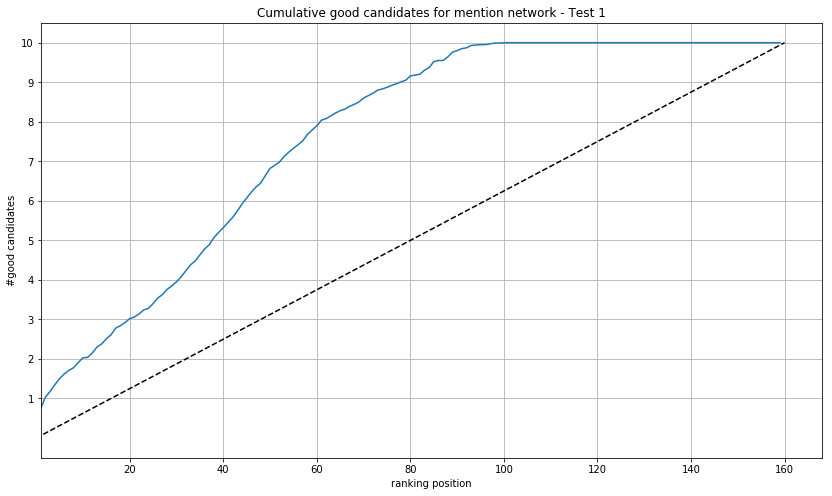

In [69]:
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
    
    # test ids needed to filter the following users (they are not included in the ranking)
    testusers = pd.read_csv('data-random/user.csv', sep='\t')
    test_ids = list(map(str, testusers[testusers['n_test'] == test]['id_user'].unique()))
    allseeds = list(map(int, allseeds))
    
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'social_network_{}_following_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'social_network_{}_following.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','followers','following','id_user']+header
    
    # add username column to avoid error
    data['username'] = 'not_kept'
    
    # keeps only seeds and test users for the evaluation
    data = data[data['id_user'].isin(test_ids + allseeds)]
    data.reset_index(inplace=True)
    
    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['id_user']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)

    prec_20 = []
    allcentroids = []
    for seeds in combinations:
        effective_seeds = list(seeds)
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)
        
        for index, candidate in r.iterrows():
            id_user = candidate['id_user']
            all_ranking[id_user].append(index+1)
        
        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        allcentroids.append(centroid)

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for mention network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))

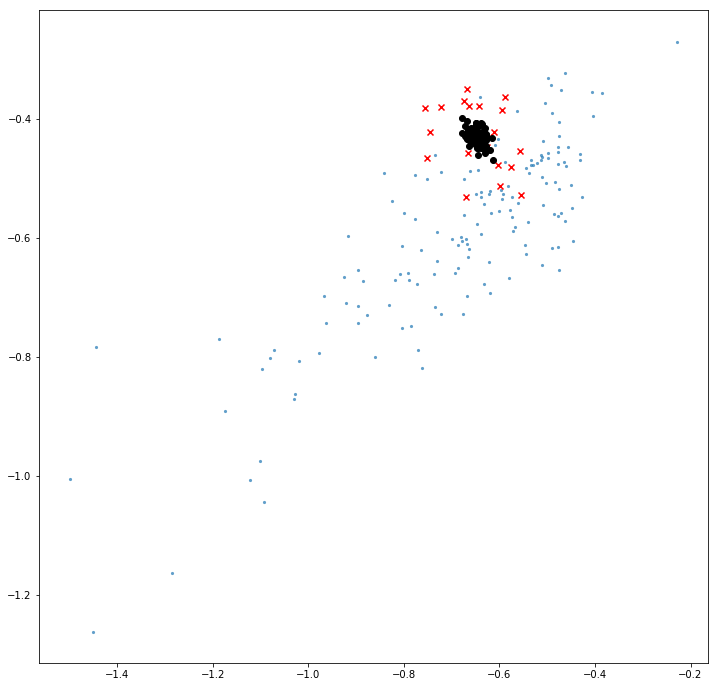

In [73]:
plotData(data[data['id_user'].isin(allseeds)], data[data['id_user'].isin(test_ids)], header, allcentroids)

In [44]:
# these are missing because they have no following, so they are not present in the network
set(testusers[testusers['n_test']==1]['id_user']) - set(data['id_user'])

{519,
 3077,
 4562,
 9258192,
 9656292,
 19812908,
 36958712,
 62985293,
 193280501,
 860061325}

In [66]:
for id_user in candidates_ranking:
    print (id_user, candidates_ranking[id_user])

36361027 [30, 62, 37, 29, 44, 46, 50, 58, 19, 36, 39, 34, 31, 45, 53, 61, 40, 13, 58, 33, 53, 45, 47, 59, 58, 37, 47, 46, 29, 24, 61, 42, 31, 39, 42, 50, 29, 61, 58, 33, 58, 65, 39, 44, 51, 54, 41, 45, 41, 54, 54, 23, 45]
104952689 [39, 52, 66, 42, 46, 60, 62, 40, 48, 17, 47, 49, 53, 45, 57, 51, 43, 49, 64, 61, 38, 60, 54, 16, 50, 47, 51, 20, 29, 56, 47, 36, 43, 48, 55, 56, 63, 51, 61, 69, 57, 54, 52, 33, 53, 48, 58, 46, 57, 57, 50]
35810531 [51, 23, 34, 35, 42, 27, 19, 51, 27, 45, 27, 39, 42, 50, 33, 21, 42, 38, 31, 52, 45, 31, 41, 10, 41, 33, 48, 45, 34, 54, 43, 40, 44, 42, 38, 54, 42, 24, 31, 32, 34]
6361512 [8, 27, 26, 11, 5, 3, 37, 33, 5, 26, 18, 13, 15, 28, 36, 13, 13, 7, 36, 15, 1, 3, 26, 5, 35, 8, 40, 18, 18, 42, 37, 15, 27, 42, 4, 38, 31, 3, 3, 8, 4, 5, 21, 7, 36, 27, 6, 27, 1, 14, 30, 22, 21, 5, 36, 14, 14]
31137628 [1, 3, 2, 24, 2, 1, 3, 18, 2, 6, 18, 29, 2, 14, 17, 1, 15, 8, 10, 3, 6, 24, 8, 2, 2, 1, 1, 29, 14, 3, 1, 18, 13, 1, 13, 24, 17, 1, 3, 14, 16, 14, 2, 34, 11, 1, 2,

In [60]:
allresult = []
for id_user in all_ranking:
    allresult.append(tuple(
        (id_user, data[data['id_user'] == id_user]['username'].values[0], np.mean(all_ranking[id_user]))
    ))

In [61]:
df_all = pd.DataFrame(allresult, columns=['id_user', 'screen_name', 'ranking']).sort_values(by='ranking')
df_all['member'] = df_all.apply(lambda x: 'seed' if x['id_user'] in allseeds else 'random', axis=1)

In [62]:
df_all

,id_user,screen_name,ranking,member
19,57268394,not_kept,2.739130,seed
44,324,not_kept,5.130000,random
101,4902972795,not_kept,5.480000,random
153,28143,not_kept,7.580000,random
100,13058,not_kept,7.720000,random
18,31137628,not_kept,9.333333,seed
85,42047590,not_kept,9.800000,random
12,327577091,not_kept,11.112903,seed
163,9320,not_kept,11.700000,random
27,47,not_kept,12.090000,random


## Followers Network Test - 1

/home/brambilla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Average P@20: 9.13


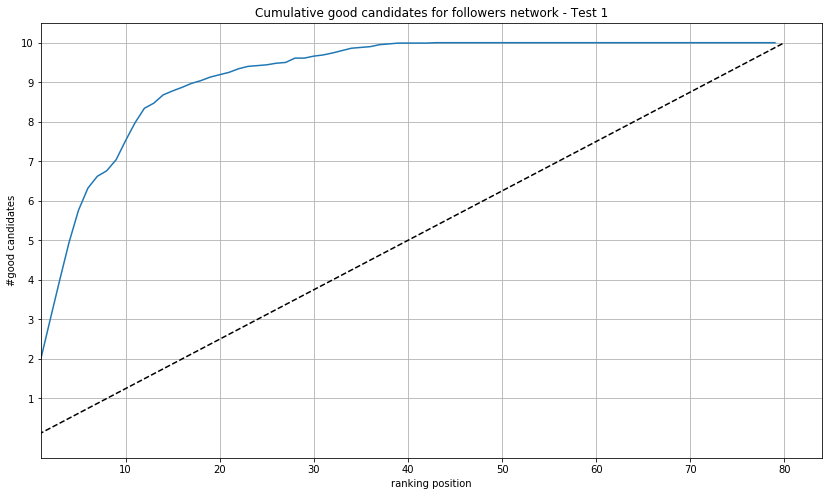

In [57]:
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
    
    # test ids needed to filter the following users (they are not included in the ranking)
    testusers = pd.read_csv('data-random/user.csv', sep='\t')
    test_ids = list(testusers[testusers['n_test'] == test]['id_user'].unique())
    allseeds = list(map(int, allseeds))
    
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'social_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'social_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','followers','following','id_user']+header
    
    # add username column to avoid error
    data['username'] = 'not_kept'
    
    # keeps only seeds and test users for the evaluation
    data = data[data['id_user'].isin(test_ids + allseeds)]
    data.reset_index(inplace=True)
    
    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['id_user']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)

    prec_20 = []
    
    for seeds in combinations:
        effective_seeds = list(map(int, seeds))
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)
        
        for index, candidate in r.iterrows():
            id_user = candidate['id_user']
            all_ranking[id_user].append(index+1)
        
        prec_20.append(cumulativeGoodCandidates(r[:20])[19])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for followers network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))

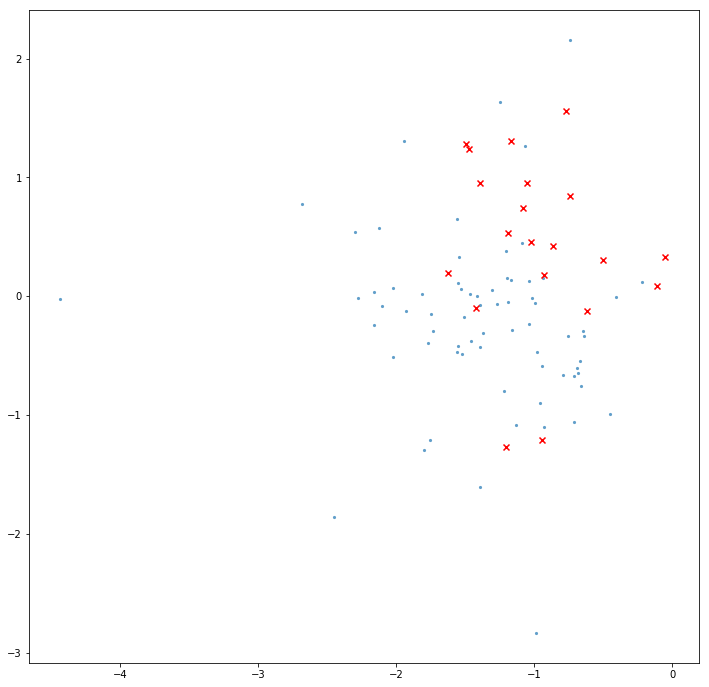

In [56]:
plotData(data[data['id_user'].isin(allseeds)], data[data['id_user'].isin(test_ids)], header)

In [58]:
set(testusers[testusers['n_test']==1]['id_user']) - set(data['id_user'])

{61,
 66,
 67,
 82,
 320,
 355,
 388,
 430,
 443,
 455,
 519,
 737,
 795,
 842,
 849,
 893,
 946,
 947,
 1199,
 3077,
 4267,
 6585,
 7306,
 7389,
 7548,
 8353,
 8458,
 8499,
 9320,
 9406,
 12601,
 13058,
 13658,
 15883,
 19773,
 28143,
 31023,
 34123,
 34203,
 51793,
 55033,
 78883,
 1485051,
 6936172,
 9258192,
 9656292,
 9736242,
 19812908,
 20325834,
 22329929,
 27774936,
 31991535,
 34033955,
 35343252,
 36958712,
 37187445,
 42285575,
 43619077,
 47688274,
 47855059,
 48558004,
 50018576,
 53562231,
 55368724,
 57902288,
 62985293,
 64742913,
 66267377,
 66842010,
 71994935,
 73562496,
 76741437,
 79969037,
 86124652,
 90386145,
 96954724,
 134084824,
 193280501,
 245891047,
 303264766,
 308523811,
 491821618,
 584963133,
 741036103,
 807442880,
 837198475,
 860061325,
 1865120570,
 2451857593,
 4902972795}